Author: Vinícius Miranda

Course: CS110, Spring 2018

## Introduction

This notebook presents a brief introduction of cuckoo filters. A Cuckoo filter is a new data structure introduced in Fan, Andersen, Kaminsky, and Mitzenmacher (2014) that both achieves higher performance than standard bloom filters and supports the dynamic deletion of items. Both bloom and cuckoo filters are probabilistic data structures that can perform space membership tests with a close-to-optimal usage of space. Filters are probabilistic because they have a small false positive error rate. This error rate is minimized to acceptable levels for a given application by manipulating the characteristics of the filter. 

Bloom filters have a wide-range of applications in which one needs to test whether an element is a member of a large set. Their significant improvement over hash tables is achieved by drastically reducing the usage of memory. Therefore, they are especially useful in applications where memory is at a premium. When these filters were introduced in the 1970s, uses included testing whether words were appropriately hyphenated, whether words were misspelled, and whether passwords were too weak to be appropriate (Broder & Mitzenmacher, 2004). More recent applications include distributed caching that aims to optimize web traffic and their integration in Postgresql aiming to reduce lookups for unexisting rows and columns (Fan, Cao, Almeida, & Broder, 2000; PostgreSQL, n.d.).            

The standard implementation of a bloom filter supports insertions and lookups, but not deletions. Several extensions have been proposed to enable the deletion operation but all decreased lookup performance or memory efficiency (Table 1). A cuckoo filter was the first introduced derivation of a bloom filter that supported the deletion of items while improving lookup performance and memory efficiency in most practical applications (Fan et al., 2014). Their main drawback, however, is that insertion running time increases with the load factor.

| filter type | space cost  | cache misses per lookup  | deletion support   |
|------|------|------|------|
| Bloom | 1|$k$| no   |
| blocked Bloom | 1x| 1   | no   |
| counting Bloom | 3x ~ 4x| $k$   | yes   |
| *d*-left counting Bloom | 1.5x ~ 2x| $d$   | yes   |
| quotient | 1x ~ 1.2x |Greater than or equal to 1| yes   |
| cuckoo |Less than or equal to 1x| 2   | yes   |
Table 1. Properties of various filters. Standard and counting Bloom filters use $k$ hash functions,
and $d$-left counting Bloom filters have $d$ partitions. Sourced from Fan et al. (2014).

## Implementation

Now, I turn to the details of the implementation of a cuckoo filter. I assume some familiarity with both bloom filters and cuckoo hashing and recommend these topics' Wikipedia pages as proper introductions. As a refresher, consider the following. The standard bloom filter consists of $k$ hash functions and a bit array with $m$ bits, whose initial value is set to $0$. Each hash function maps an item to one bit in the array to perform an insertion. All $k$ bits assigned by the $k$ hash functions are set to $1$. To look up an element, we hash it $k$ times and check all $k$ bits, returning $True$ only if all those bits are $1$. In cuckoo hashing, we have a hash table and two hash functions that map an item to two alternative positions in the array. When either or both these positions are empty, we insert the item into one of them. When both slots are occupied, we select one of these slots and kick its existing entry out to free up space for the insertion. The displaced item is relocated to its alternative position in the hash table, which may or may not be already full. If it is, we follow the same process until a free slot is found.

In a cuckoo filter, we store only $fingerprints$ of the elements instead of key-value pairs (as in a cuckoo hash table) or a single bit (as in a bloom filter). These fingerprints are bit strings obtained by applying a hash function to the item. The size of the fingerprint is determined by the desired false positive rate $\epsilon$. Longer fingerprints require more space but yield smaller $\epsilon$. Moreover, similar to practical implementations of cuckoo hashing, cuckoo filters may implement buckets able to hold multiple items (Dietzfelbinger & Weidling, 2007; Fan et al., 2007). Therefore, a filter is as an array of buckets, each of them able to store multiple entries or fingerprints.

Insertion is the most complicated operation so that I will explain it last. Lookup, on the other hand, is very simple. We first calculate the fingerprint and the two possible buckets of a given item. Then, we test whether either of those buckets contains the fingerprint. If so, we return true; if not, we return false. Notice that different items can have the same fingerprint, so it is possible that both locations contain the fingerprint. Our lookup would still return true given that one of these should correspond to the element for which we are searching. False negatives can never occur given that we are testing for all possible locations of an item. Finally, notice that the algorithm performs a constant number of operations regardless of the size of the filter or the input. Thus, the running time complexity of lookup is $\Theta(1)$. 

Deletion is very similar to the lookup operation. We calculate the fingerprint, two possible buckets, and test whether either of those buckets contains the item's fingerprint. If so, instead of returning true as in the lookup, we remove the fingerprint. The hash functions presented later in the notebook secure one fundamental property: if items have the same fingerprint stored in the same bucket, then their alternative bucket is also the same. Therefore, there is no case in which we delete the "wrong" fingerprint when there are repeated entries in one bucket. The deletion algorithm will remove only one of these entries and leave the others untouched, securing the correctness of future lookups or deletions. This algorithm also performs a constant number of operations and has a running time complexity of $\Theta(1)$.

I now turn to the insertion operation. As mentioned above, in cuckoo hashing we relocate an existing entry to its alternative position to free up space for the item we are trying to insert. However, in cuckoo filters, this procedure is complicated given that we no longer have access to the item itself, only to its fingerprint. Therefore, the challenge is of how to store new items *dynamically* even though we cannot rehash an item to compute its alternative location. A technique called *partial-key cuckoo hashing* can be used to circumvent this problem. With this technique, the two possible buckets of an item are calculated with the following hash functions:
$$h_1(x) = hash(x),\\ h_2(x) = h_1(x) \oplus hash(x's\ fingerprint).$$
The xor operation in the equation above guarantees that we can calculate $h_1(x)$ from $h_2(x)$ and the fingerprint using the same formula. In other words, for buckets indexed  by $i$ and $j$ and a fingerprint $y$, we have both

$$i = j \oplus hash(y), and \\ j = i \oplus hash(y).$$

Therefore, the relocation of a fingerprint can take place without retrieving the original item. The complete insertion algorithm runs as follows. We compute the item's fingerprint and two possible buckets. If either of these buckets has available space, we add the fingerprint, and the function returns. If both buckets are full, we select one bucket and one entry randomly. We swap the fingerprint we aim to insert with the one in that entry. Now, we must relocate the displaced fingerprint. To do so, we compute its alternative bucket and try to place it there. If the target bucket is full, we repeat the process of displacing an existing fingerprint and calculating its alternative bucket. We attempt this process $n$ times. If the algorithm is unable to find a free bucket in $n$ iterations, it terminates in a failure mode, and the filter is considered full.       

There are three main weaknesses associated with this strategy. First, the number of operations executed when inserting in a cuckoo filter increases with its load factor. Fan et al. (2014) apply an upper bound to the number of displacements to limit the running time of the insertion procedure. An analysis of its scaling behavior before the limit is not explored by Fan et al. (2014) and remains a topic for future research. Moreover, the number of possible pairs ($h_1$, $h_2$) calculated with partial-key cuckoo hashing can be much smaller than under an optimal hashing scheme. For example, if we use a 4-bit fingerprint, the alternative buckets of an item would be at most 16 buckets away from the original bucket. This proximity is due to the fact that the xor operation would alter only the 4 lower order bits of the item's bucket index. Empirical tests should show whether the number of collisions generated by this hashing scheme is too high for the data structure to be practical. Finally, I noted above that it is possible to have repeated fingerprints stored in the same bucket. However, we are only able to deal with a limited number of repetitions given that these fingerprints will always map to the same alternative buckets. Therefore, the same item (or items with the same fingerprint) cannot be inserted more than $2b$ times, where $b$ is the bucket size of the cuckoo filter.


## Scaling Behavior
    
The analysis of the scaling of cuckoo filter properties is harder than that of bloom filters. For example, whereas the memory size of bloom filters is a function of the bit array size only, the memory usage of cuckoo filters depend on the array size, the bucket size, and fingerprint length. The explanations above are targeted to a general audience and I do not provide mathematical proofs for the equations shown. A more technical exposition is provided in Fan et al. (2007).

**Space Efficiency**

First, I consider the association between the size of the filter and the length of the fingerprint, which will help us understand the filter's memory efficiency. As we saw in the description of the insertion procedure, new items are rejected when the filter is full (i.e., when the algorithm fails to find a free bucket). For $q$ items to share the same two buckets, they must have the same fingerprint and hash to the same two buckets. The probability that that occurs is $\big(\frac{2}{m}*\frac{1}{2^f}\big)^{q-1}$ (Fan et al., 2007). For an insertion to fail, $q = 2b+1$ items should map to the same bucket. Furthermore, there are ${n \choose 2b+1}$ different possible sets of $2b+1$ items when $n$ items will be inserted into the filter. Thus, for a table of size $m = cn$ where $c$ is constant larger than one, the lower bound for the probability of failure is

$${n \choose 2b+1}\bigg(\frac{2}{2^f*m}\bigg)^{2b} = {n \choose 2b+1}\bigg(\frac{2}{2^f*cn}\bigg)^{2b} = \Omega\bigg(\frac{n}{4^{bf}}\bigg).$$

Again, a fuller exposition is provided in Fan et al. (2007), where the authors derive from this lower bound that the fingerprint size scales $\Omega(\log n)$. This result is a key difference between bloom and cuckoo filters. Bloom filters use a constant space per item (approximately $\ln(1/\epsilon)$, where $\epsilon$ is the target error rate). If fingerprint sizes scale logarithmically with $n$, we might be worried that memory use in the cuckoo filter will be inferior. However, memory efficiency will depend on the occupancy of the hash table $\alpha$, which in turns depend on the bucket size $b$. Namely, the more items we can insert before the filter is considered full, the higher its memory efficiency will be. Fan et al. (2014) prove that the constant factors in the scaling of the required fingerprint size of a cuckoo filter are low enough that it is more efficient than bloom filter for $n$ in the order of billions of entries. I do not replicate this finding here to focus solely on testing the theoretical upper bound of the false positive rate $\epsilon$.

The memory efficiency of a cuckoo filter is measured as the space cost $C$ of each item, calculated through the ratio of the filter size and the number of items stored in the filter: 

$$C = \frac{filter\ size}{\#\ of\ items} = \frac{f * (\#\ of\ entries)}{\alpha * (\#\ of\ entries)} = \frac{f}{\alpha}\ bits.$$

This equation has an intuitive interpretation. For fully occupied filters (i.e., $\alpha = 1$), the cost per item is the fingerprint size. Otherwise, space is wasted in free entries that are not filled, increasing the associated memory cost per item.

Another important difference between bloom and cuckoo filters is that in the latter, we can provide an upper bound to the false positive rate. The reasoning follows. The worst case for the lookup of an unexisting item happens when both buckets to which the item is mapped are full with $b$ entries each. The probability that the item's fingerprint matches with an existing entry is at most $1/2^f$, where $2^f$ is the maximum number of unique fingerprints. Naturally, a uniform distribution of fringerprint values is assumed and usually guaranteed by a good choice of hash function. Therefore, for $2b$ comparisons, the likelihood of a false positive is

$$1 - (1 - \frac{1}{2^f})^{2b} \approx \frac{2b}{2^f} \leq \epsilon,$$

where $\epsilon$ is the target error rate. We can thus derive a lower bound to the fingerprint size as

$$f \geq \lceil\log_2(2b/\epsilon)\rceil = \lceil\log_2(1/\epsilon) +\log_2(2b)\rceil\ bits.$$

We use this equation to provide an upper bound to the average space cost $C$, which becomes:

$$C \leq \lceil \log_2(1/\epsilon)+\log_2(2b)\rceil/\alpha,$$

or

$$C \leq \lceil \log_2(1/\epsilon)+\log_2(2b)\rceil * \frac{m}{n},$$

given that $\alpha=n/m$, where $m$ is the number of entries in the filter and $n$ is the number of items inserted. This final equation shows how space efficiency is affected by the parameters of the filter.

**Performance of Key Operations** 

I provide a short analysis of the performance of lookup, deletion, and insertion. The lookup algorithm computes an item's fingerprint and hash values and checks whether one of the two possible buckets contains the fingerprint. The first computation always happens in constant time, whereas we need to traverse the bucket in other to look for the fingerprint. For buckets of size $b$, we should check at most $2b$ positions when both possible buckets are full. Therefore, the lookup operation is a cuckoo filter is $O(2b) + O(1)$ or $O(b)$. We may wish to apply the relationship $2b/2^f \leq \epsilon$, shown above to analyze the scaling of lookup as a function of the error rate and fingerprint size. Note, however, that because we know only the upper bound of $\epsilon$, we have no guarantees that we have found a tight bound. Therefore, lookup scales $o(\epsilon*2^f)$. Given that $b$ is not affected by the number of items $n$, lookup time is constant for a given filter. The same rationale applies to the delete operation.

The asymptotic analysis of the running time of insertion is an open question which the original authors did not explore (Pan et al., 2007). Trivially, once a maximum number of swaps is defined, the worst-case running time is bound by the set number of iterations. I do not pursue here an analysis of the complexity of insertion. Table 2 shows a comparison of the scaling behavior of cuckoo and bloom filters.

|  | Cuckoo Filter  | Bloom Filter  | 
|------|------|------|
| Insert | Increases with $\alpha$. Trivial O(1)\* | O(k)   |
| False Positive Rate | Grows toward a set maximum| Grows toward 100%   |
| Rejections | Insertions may be rejected| Insertions cannot be rejected   |
| Lookup | O(1) | O(k)   |
| Delete | O(1) | *unsupported*   |
Table 2. A comparison of cuckoo and bloom filters across key operations. Adapted from Anonymous (n.d.). \*Considering the upper bound on the number of iterations, there is a constant and maximum number of operations never exceed during insertion. Thus, there is a trivial O(1) bound.

**HC Applied:** #estimation. I apply sound quantitative reasoning to estimate an upper bound to the false positive rate of a cuckoo filter. The empirical test below proves the correctness of the upper bound and is a well-implemented demonstration of  the false positive rate. Assumptions are stated and justified (e.g., uniformity of the distribution of fingerprints).

## Test of the Error Rate

I provide implementation code for the cuckoo filter below and test the theoretical upper bound of the error rate $\epsilon$. The test is set up as follows. I create a list of one million random words of length 20. Then, I create multiple filters with 1000 buckets, a fingerprint size of one byte, and bucket sizes that vary from 1 to 10. Using the formula $2b/2^f \leq \epsilon$, I derive the theoretical upper bound of the error rate. To calculate the empirical error rate, I insert words into the filter until it is full, and then perform lookups for all the words we know that have not been inserted. The empirical error rate is calculated as the ratio of the number of positives (which we know to be incorrect) over the number of lookups. I run the simulation then times for each bucket size and take the average of the error rate. Figure 1 shows that our filter indeed guarantees that the empirical error rate is never greater than the theoretical upper bound even when the filter is full. 

In [2]:
"""
This code is partially adapted from
https://github.com/michael-the1/python-cuckoo
"""

import random
import mmh3

class Bucket:
    '''Bucket class for storing fingerprints.'''

    def __init__(self, size=4):
        '''
        Initialize bucket.
        
        size : the maximum nr. of fingerprints the bucket can store
            Default size is 4.
        '''
        self.size = size
        self.b = []

    def insert(self, fingerprint):
        '''
        Insert a fingerprint into the bucket.
        The insertion of duplicate entries is allowed.
        '''
        if not self.is_full():
            self.b.append(fingerprint)
            return True
        return False

    def contains(self, fingerprint):
        return fingerprint in self.b

    def delete(self, fingerprint):
        '''
        Delete a fingerprint from the bucket.
        Returns True if the fingerprint was present in the bucket.
        This is useful for keeping track of how many items are present in the filter.
        '''
        try:
            del self.b[self.b.index(fingerprint)]
            return True
        except ValueError:
            # This error is explicitly silenced.
            # It simply means the fingerprint was never present in the bucket.
            return False

    def swap(self, fingerprint):
        '''
        Swap a fingerprint with a randomly chosen fingerprint from the bucket.
        
        The given fingerprint is stored in the bucket.
        The swapped fingerprint is returned.
        '''
        bucket_index = random.choice(range(len(self.b)))
        fingerprint, self.b[bucket_index] = self.b[bucket_index], fingerprint
        return fingerprint

    def is_full(self):
        return len(self.b) >= self.size

    def __contains__(self, fingerprint):
        return self.contains(fingerprint)

    def __repr__(self):
        return '<Bucket: ' + str(self.b) + '>'

    def __sizeof__(self):
        return super().__sizeof__() + self.b.__sizeof__()

class CuckooFilter:
    '''
    A Cuckoo filter is a data structure for probablistic set-membership queries.
    We can insert items into the filter and, with a very low false positive probability (FPP),
    ask whether it contains an item or not. Cuckoo filters serve as a drop-in replacement for
    Bloom filters, but are more space-efficient and support deletion of items.
    '''

    def __init__(self, capacity, fingerprint_size, bucket_size=4, max_kicks=500):
        '''
        Initialize Cuckoo filter parameters.
        
        capacity : size of the filter
            Defines how many buckets the filter contains.
        fingerprint_size: size of the fingerprint in bytes
            A larger fingerprint size results in a lower FPP.
        bucket_size : nr. of entries a bucket can hold
            A bucket can hold multiple entries.
            Default size is 4.
        max_kicks : nr. of times entries are kicked around before deciding the filter is full
            Defaults to 500. 
        '''
        
        self.capacity = capacity
        self.fingerprint_size = fingerprint_size
        self.max_kicks = max_kicks
        self.buckets = [Bucket(size=bucket_size) for _ in range(self.capacity)]
        self.size = 0
        self.bucket_size = bucket_size

    def insert(self, item):
        '''
        Inserts a string into the filter.
        Throws an exception if the insertion fails.
        '''
        self.size = self.size + 1
        fingerprint = self.fingerprint(item)
        i1, i2 = self.calculate_index_pair(item, fingerprint)

        if self.buckets[i1].insert(fingerprint):
            return i1
        elif self.buckets[i2].insert(fingerprint):
            return i2

        i = random.choice((i1, i2))
        for kick_count in range(self.max_kicks):
            fingerprint = self.buckets[i].swap(fingerprint)
            i = (i ^ self.index_hash(fingerprint)) % self.capacity

            if self.buckets[i].insert(fingerprint):
                return i

        self.size = self.size - 1
        raise Exception('Filter is full')

    def contains(self, item):
        '''Checks if a string was inserted into the filter.'''
        fingerprint = self.fingerprint(item)
        i1, i2 = self.calculate_index_pair(item, fingerprint)
        return (fingerprint in self.buckets[i1]) or (fingerprint in self.buckets[i2])

    def delete(self, item):
        '''Removes a string from the filter.'''
        fingerprint = self.fingerprint(item)
        i1, i2 = self.calculate_index_pair(item, fingerprint)
        if self.buckets[i1].delete(fingerprint) or self.buckets[i2].delete(fingerprint):
            self.size = self.size - 1
            return True
        return False

    def index_hash(self, item):
        '''Calculate the (first) index of an item in the filter.'''
        item_hash = mmh3.hash_bytes(item)
        index = int(item_hash.encode('hex'), 16) % self.capacity
        # Python 3: index = int.from_bytes(item_hash, byteorder='big') 
        return index

    def calculate_index_pair(self, item, fingerprint):
        '''Calculate both possible indices for the item'''
        i1 = self.index_hash(item)
        i2 = (i1 ^ self.index_hash(fingerprint)) % self.capacity
        return i1, i2

    def fingerprint(self, item):
        '''
        Takes a string and returns its fingerprint in bits.
        The length of the fingerprint is given by fingerprint_size.
        To calculate this fingerprint, 
        we hash the string with MurmurHash3 and truncate the hash.
        '''
        item_hash = mmh3.hash_bytes(item)
        return item_hash[:self.fingerprint_size]

    def load_factor(self):
        return self.size / (self.capacity * self.bucket_size)

    def __contains__(self, item):
        return self.contains(item)

    def __repr__(self):
        return '<CuckooFilter: capacity=' +str(
            self.capacity) + ', fingerprint size=' + str(
            self.fingerprint_size) + ' byte(s)>'

    def __sizeof__(self):
        return super().__sizeof__() + sum(b.__sizeof__() for b in self.buckets)

In [ ]:
import numpy as np
import random
import string

def generate_words(n, l=10):
    '''
    This function creates a list of n random words of size 
    l to be inserted into the cuckoo filter.
    '''
    return [''.join(random.choice(
            string.ascii_lowercase + string.ascii_uppercase + string.digits) 
                    for _ in range(l)) for word in range(n)]

data = generate_words(1000000, 20)
print "complete."

numRuns = 10
sizes = range(1, 11)

# Calculate theoretical errors.
theoretical_error = [2.*100*x/2**8 for x in sizes]

# For these configurations
errors = []
for size in sizes:
    this_error = []
    for i in range(numRuns):
        # Build the filter
        cuckoo = CuckooFilter(capacity=1000, 
                              fingerprint_size=1, 
                              bucket_size=size)

        # Insert until full
        entry_count = 0
        while True:
            try:
                entry_count += 1
                cuckoo.insert(data[entry_count])
            except:
                break

        # Check the empirical rate
        false_positive_count = 0.
        for i in range(entry_count, len(data)): 
            if data[i] in cuckoo:
                false_positive_count += 1

        this_error.append(false_positive_count*100./(len(data) - entry_count))
    errors.append(np.mean(this_error))

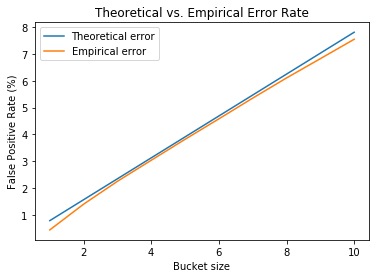

In [24]:
'''
Figure 1. A comparison of theoretical and empirical false positive rates.
For each bucket size, empirical rate is an average over 10 simulations.
'''

import matplotlib.pyplot as plt
plt.plot(sizes, theoretical_error, label = "Theoretical error")
plt.plot(sizes, errors, label = "Empirical error")
plt.xlabel("Bucket size")
plt.ylabel("False Positive Rate (%)")
plt.title("Theoretical vs. Empirical Error Rate")
plt.legend()
plt.show()


### References

Anonymous. (n.d.). Probabilistic Filters By Example. Retrieved from: https://bdupras.github.io/filter-tutorial/

Broder, A., & Mitzenmacher, M. (2004). Network applications of bloom filters: A survey. *Internet mathematics, 1*(4), 485-509.

Dietzfelbinger, M., & Weidling, C. (2007). Balanced allocation and dictionaries with tightly packed constant size bins.* Theoretical Computer Science, 380*(1):47–68.

Fan, B., Andersen, D. G., Kaminsky, M., & Mitzenmacher, M. D. (2014, December). Cuckoo filter: Practically better than bloom. In *Proceedings of the 10th ACM International on Conference on emerging Networking Experiments and Technologies* (pp. 75-88). ACM.

Fan, L., Cao, P., Almeida, J., & Broder, A. Z. (2000). Summary cache: a scalable wide-area web cache sharing protocol. *IEEE/ACM transactions on networking, 8*(3), 281-293.

PostgreSQL. (n.d.). F.5. bloom. Retrieved from: https://www.postgresql.org/docs/10/static/bloom.html

